# Проект. Разведывательный анализ данных.
Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

Задача: подготовить данные для дальнейшего построения модели.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv("stud_math.csv")

### 1. Первичный анализ и подготовка данных и функции для работы с данными

In [3]:
# Создание списков columns04, columns14 и columns15 с именами переменных с ограниченными диапазонами значений, 0-4, 1-4, 1-5
columns04 = ['Medu', 'Fedu']
columns14 = ['traveltime', 'studytime']
columns15 = ['famrel', 'freetime', 'goout', 'health']


def view_string_column(df, column):
    """Обзор столбцов со строковыми значениями,
    вывод значений и их колличество, а так же
    колличество пустых значений"""
    if df[column].dtype == 'object':
        display(df[column].value_counts())
        print('{} - NaN'.format(len(df[column][df[column].isna()])))
        print('Уникальных значений', df[column].nunique(), '\n')
    return None


def view_numeric_column(df, column):
    """Обзор столбцов с числовыми значениями,
    вывод значений и их колличество, а так же
    колличество пустых значений"""
    if df[column].dtype == 'float64':
        display(df[column].value_counts())
        print('{} - NaN\n'.format(len(df[column][df[column].isna()])))
    return None


def draw_hist(df, column):
    """Отрисовка хистограммы"""
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 1, 1])
    axes.hist(df[column])
    axes.set_title(column)
    return None


def draw_numeric_column(df, column):
    """Отрисовка гистограм слотбцов с числовыми значениями"""
    if df[column].dtype == 'float64':
        draw_hist(df, column)
    return None


def out_values(df, column, inter='linear'):
    """Поиск выбросов в датафрейме df, колонке column, inter - интерполяция
    для определения квртитилей. Функция возвращает новую колонку с выбросами замененными
    пустыми значениями"""
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(q=0.25, interpolation=inter)
    perc75 = df[column].quantile(0.75, interpolation=inter)
    return df[column].apply(lambda x: None if x < (perc25 - 1.5*iqr) or x > (perc75 + 1.5*iqr) else x)


def out_values_range(df, column, val_range):
    """Поиск выбросов в столбцах с определенными значениями,
    ограниченными диапазонами val_range, в датафрейме df, колонке column.
    Функция возвращает новую колонку с выбросами замененными
    пустыми значениями"""
    x, y = val_range
    return df[column].apply(lambda c: c if ((c % 1) == 0) and (c in range(x, y)) else None)


def fillna_median(df, column):
    """Заполнение пустых значений в датафрейме df колонке column медианными значениями
    Функция возвращает новую колонку с заполенными значениями"""
    return df[column].fillna(df[column].median())


def get_boxplot(df, column):
    """Обзор распределения баллов(score) в зависимости от значений номинальных переменных
    с помощью графиков box-plot"""
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(df, column):
    """Поиск зависимости значении балов(score) и значений номинальных переменных
    с помощью теста Стьюдента. Функция возвращает текстовую строку о наличии или отсутствии
    зависимости"""
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                     df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
    else:
        print('Cтатистически значимые различия для колонки', column, 'не найдены!')

In [4]:
# получение информации о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

### 2. Посмотр на распределение признака для числовых переменных, устранение выбросов.

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

0 - NaN



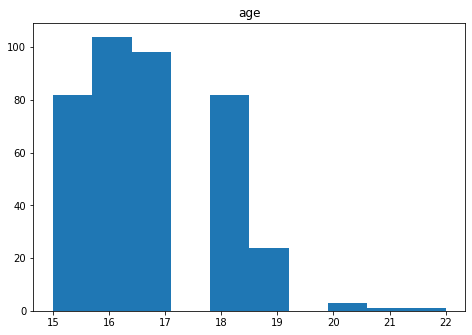

In [5]:
# обзор целочисленной переменной age, с заданным диапазоном значение 15-22
draw_hist(df, 'age')
display(df['age'].value_counts())
print('{} - NaN\n'.format(len(df['age'][df['age'].isna()])))

4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
Name: Medu, dtype: int64

3 - NaN



2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: Fedu, dtype: int64

24 - NaN



1.0    242
2.0     96
3.0     22
4.0      7
Name: traveltime, dtype: int64

28 - NaN



2.0    194
1.0    103
3.0     64
4.0     27
Name: studytime, dtype: int64

7 - NaN



0.0    293
1.0     49
2.0     16
3.0     15
Name: failures, dtype: int64

22 - NaN



-6.0     194
-3.0     103
-9.0      64
-12.0     27
Name: studytime, granular, dtype: int64

7 - NaN



 4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

27 - NaN



3.0    153
4.0    112
2.0     63
5.0     38
1.0     18
Name: freetime, dtype: int64

11 - NaN



3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
Name: goout, dtype: int64

8 - NaN



5.0    138
3.0     89
4.0     63
1.0     47
2.0     43
Name: health, dtype: int64

15 - NaN



0.0      111
2.0       60
4.0       53
6.0       31
8.0       21
10.0      17
12.0      12
14.0      12
3.0        8
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64

12 - NaN



50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

6 - NaN



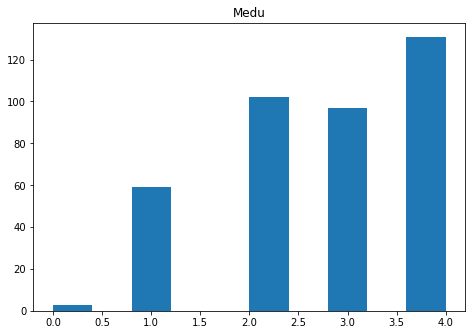

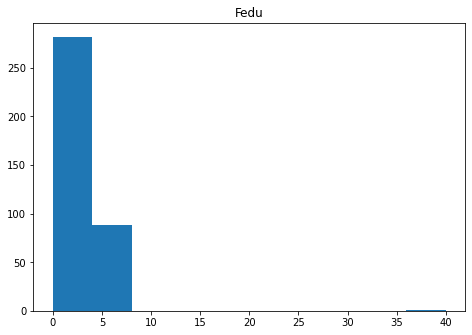

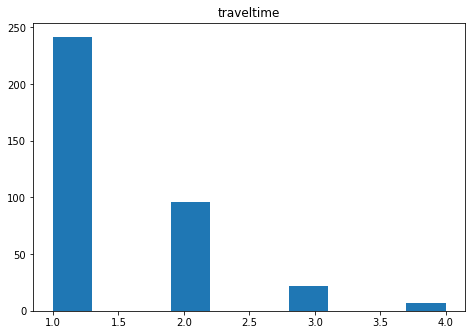

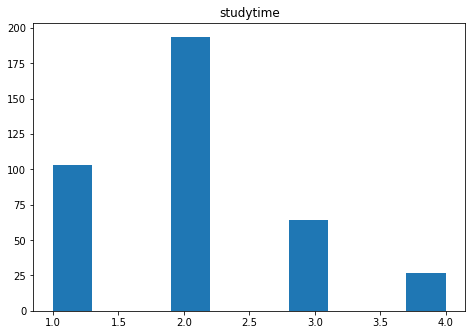

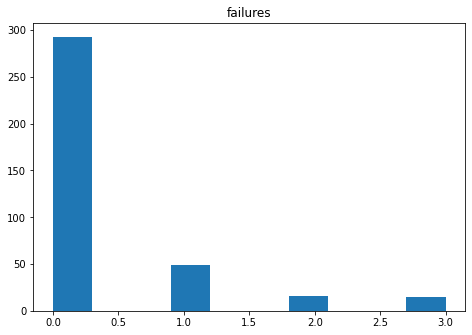

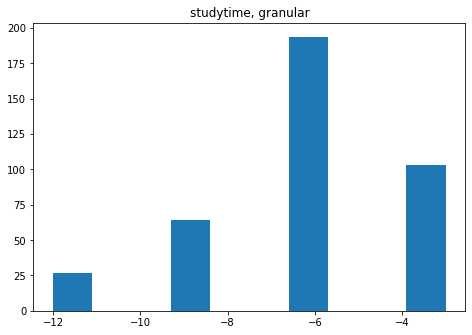

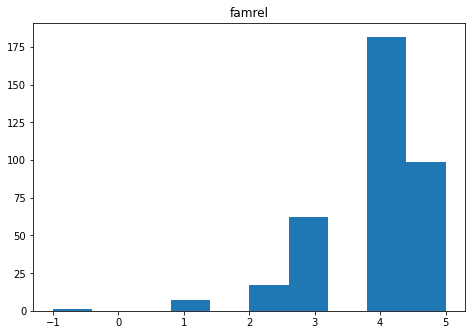

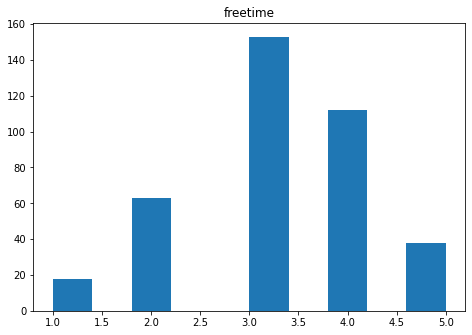

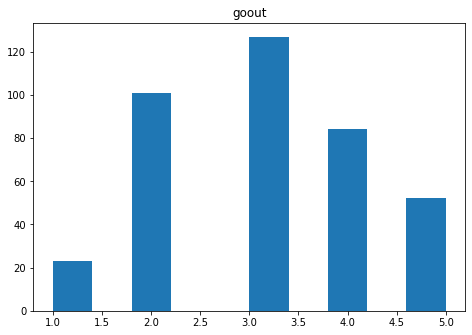

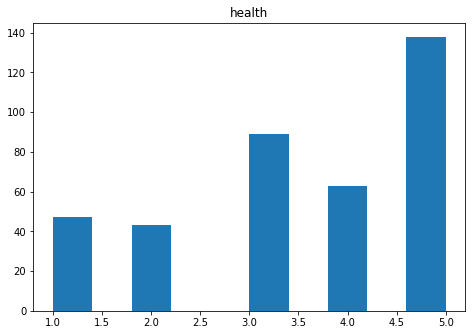

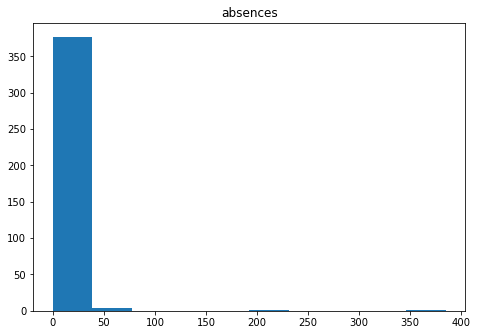

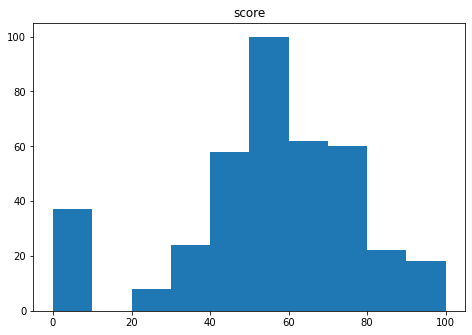

In [7]:
# первичный обзор числовых, вещественных переменных, отрисовка гистограмм
for column in df.columns:
    view_numeric_column(df, column)
    draw_numeric_column(df, column)

In [8]:
# поиск и удаление выбросов в столбцах о ограничеными значениями
for column in columns04:
    df[column] = out_values_range(df, column, (0, 5))
for column in columns14:
    df[column] = out_values_range(df, column, (1, 5))
for column in columns15:
    df[column] = out_values_range(df, column, (1, 6))
df['failures'] = out_values_range(df, 'failures', (0, 4))

In [9]:
# поиск и удаление значение в стобце Score
df['score'] = out_values(df, 'score')

In [10]:
# поиск и удаление значение в стобце absences, использование метода интерполяции midpoint
df['absences'] = out_values(df, 'absences', inter='midpoint')

In [11]:
# удаление строк с пустыми значениями Score
df = df.loc[df.score.notna()]

In [12]:
# заполннение пустых значение медианными, в столбцах с фиксированными значениеми
for column in columns04:
    df[column] = fillna_median(df, column)
for column in columns14:
    df[column] = fillna_median(df, column)
for column in columns15:
    df[column] = fillna_median(df, column)

In [13]:
# запонение пустых значение средними в столбце Absences
df['absences'] = df['absences'].fillna(round(df['absences'].mean()))

4.0    131
2.0    100
3.0     99
1.0     56
0.0      3
Name: Medu, dtype: int64

0 - NaN



2.0    105
3.0     94
4.0     88
1.0     75
2.5     25
0.0      2
Name: Fedu, dtype: int64

0 - NaN



1.0    267
2.0     94
3.0     21
4.0      7
Name: traveltime, dtype: int64

0 - NaN



2.0    196
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64

0 - NaN



0.0    290
1.0     48
2.0     15
3.0     14
Name: failures, dtype: int64

22 - NaN



-6.0     189
-3.0     103
-9.0      63
-12.0     27
Name: studytime, granular, dtype: int64

7 - NaN



4.0    206
5.0     97
3.0     62
2.0     17
1.0      7
Name: famrel, dtype: int64

0 - NaN



3.0    161
4.0    110
2.0     63
5.0     37
1.0     18
Name: freetime, dtype: int64

0 - NaN



3.0    133
2.0    101
4.0     81
5.0     51
1.0     23
Name: goout, dtype: int64

0 - NaN



5.0    137
3.0     88
4.0     75
1.0     47
2.0     42
Name: health, dtype: int64

0 - NaN



0.0     110
2.0      60
4.0      52
5.0      33
6.0      30
8.0      20
10.0     17
14.0     12
12.0     12
16.0      7
3.0       7
7.0       6
18.0      5
20.0      4
1.0       3
9.0       3
11.0      2
13.0      2
15.0      2
19.0      1
17.0      1
Name: absences, dtype: int64

0 - NaN



50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

0 - NaN



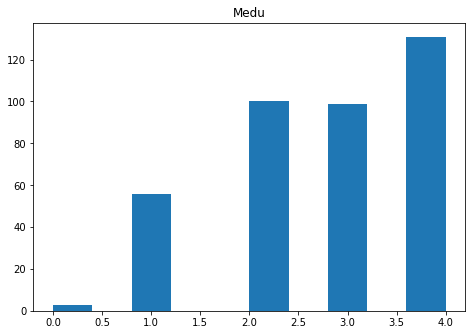

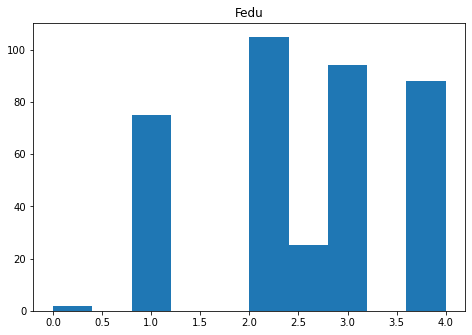

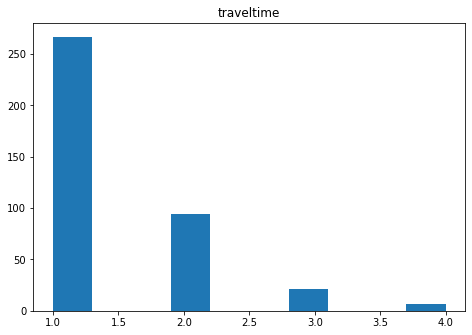

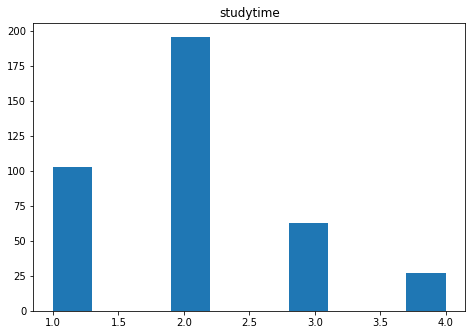

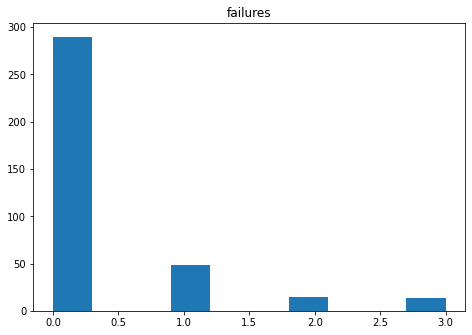

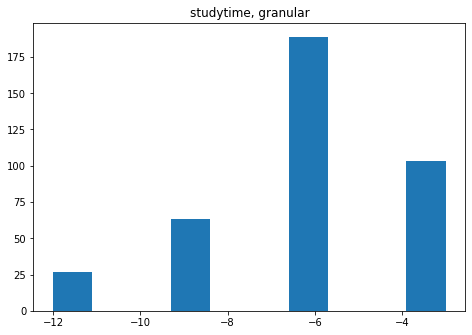

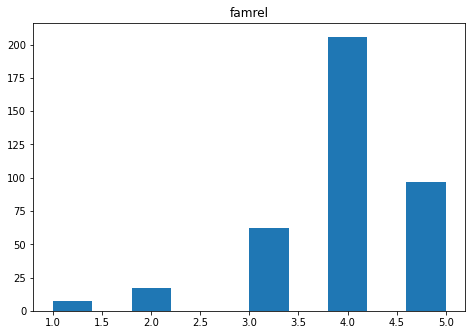

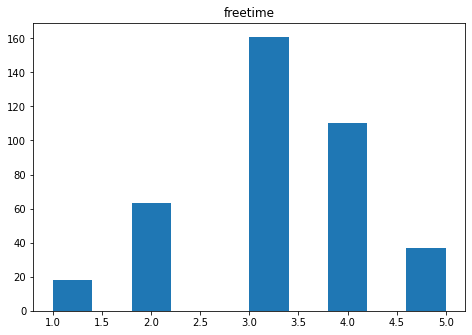

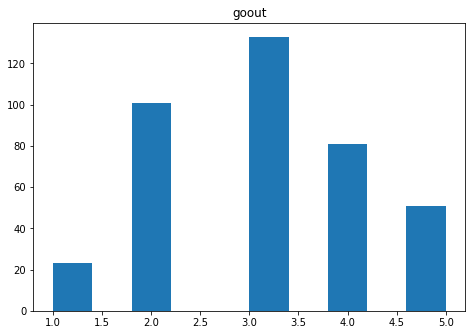

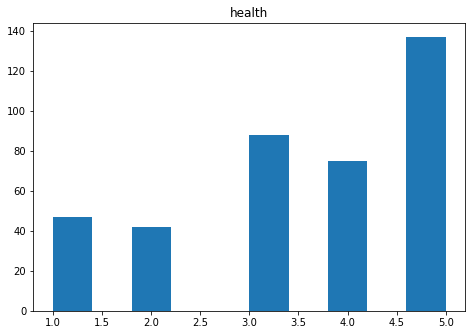

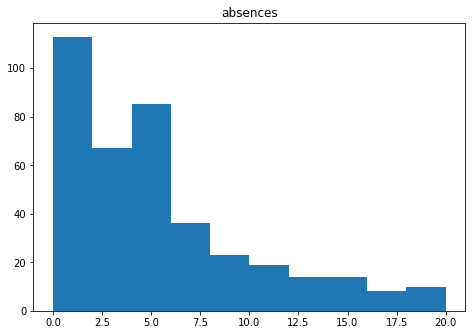

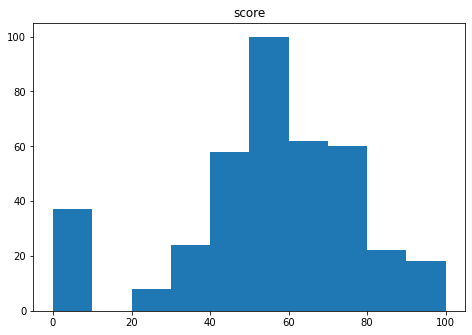

In [14]:
# итоговый обзор числовых, вещественных переменных, отрисовка гистограмм
for column in df.columns:
    view_numeric_column(df, column)
    draw_numeric_column(df, column)

### 3. Обзор номинативных переменных, определение пустых и уникальных значений

In [15]:
# обзор номинативных переменных
for column in df.columns:
    view_string_column(df, column)

GP    344
MS     45
Name: school, dtype: int64

0 - NaN
Уникальных значений 2 



F    204
M    185
Name: sex, dtype: int64

0 - NaN
Уникальных значений 2 



U    291
R     83
Name: address, dtype: int64

15 - NaN
Уникальных значений 2 



GT3    255
LE3    107
Name: famsize, dtype: int64

27 - NaN
Уникальных значений 2 



T    308
A     36
Name: Pstatus, dtype: int64

45 - NaN
Уникальных значений 2 



other       127
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64

19 - NaN
Уникальных значений 5 



other       194
services     99
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

36 - NaN
Уникальных значений 5 



course        135
reputation    102
home          101
other          34
Name: reason, dtype: int64

17 - NaN
Уникальных значений 4 



mother    248
father     86
other      24
Name: guardian, dtype: int64

31 - NaN
Уникальных значений 3 



no     331
yes     49
Name: schoolsup, dtype: int64

9 - NaN
Уникальных значений 2 



yes    216
no     135
Name: famsup, dtype: int64

38 - NaN
Уникальных значений 2 



no     197
yes    153
Name: paid, dtype: int64

39 - NaN
Уникальных значений 2 



yes    192
no     183
Name: activities, dtype: int64

14 - NaN
Уникальных значений 2 



yes    297
no      77
Name: nursery, dtype: int64

15 - NaN
Уникальных значений 2 



yes    350
no      19
Name: higher, dtype: int64

20 - NaN
Уникальных значений 2 



yes    300
no      55
Name: internet, dtype: int64

34 - NaN
Уникальных значений 2 



no     235
yes    123
Name: romantic, dtype: int64

31 - NaN
Уникальных значений 2 



### 4. Проведение коррелиционного анализа аолличественных пременных, отбор 

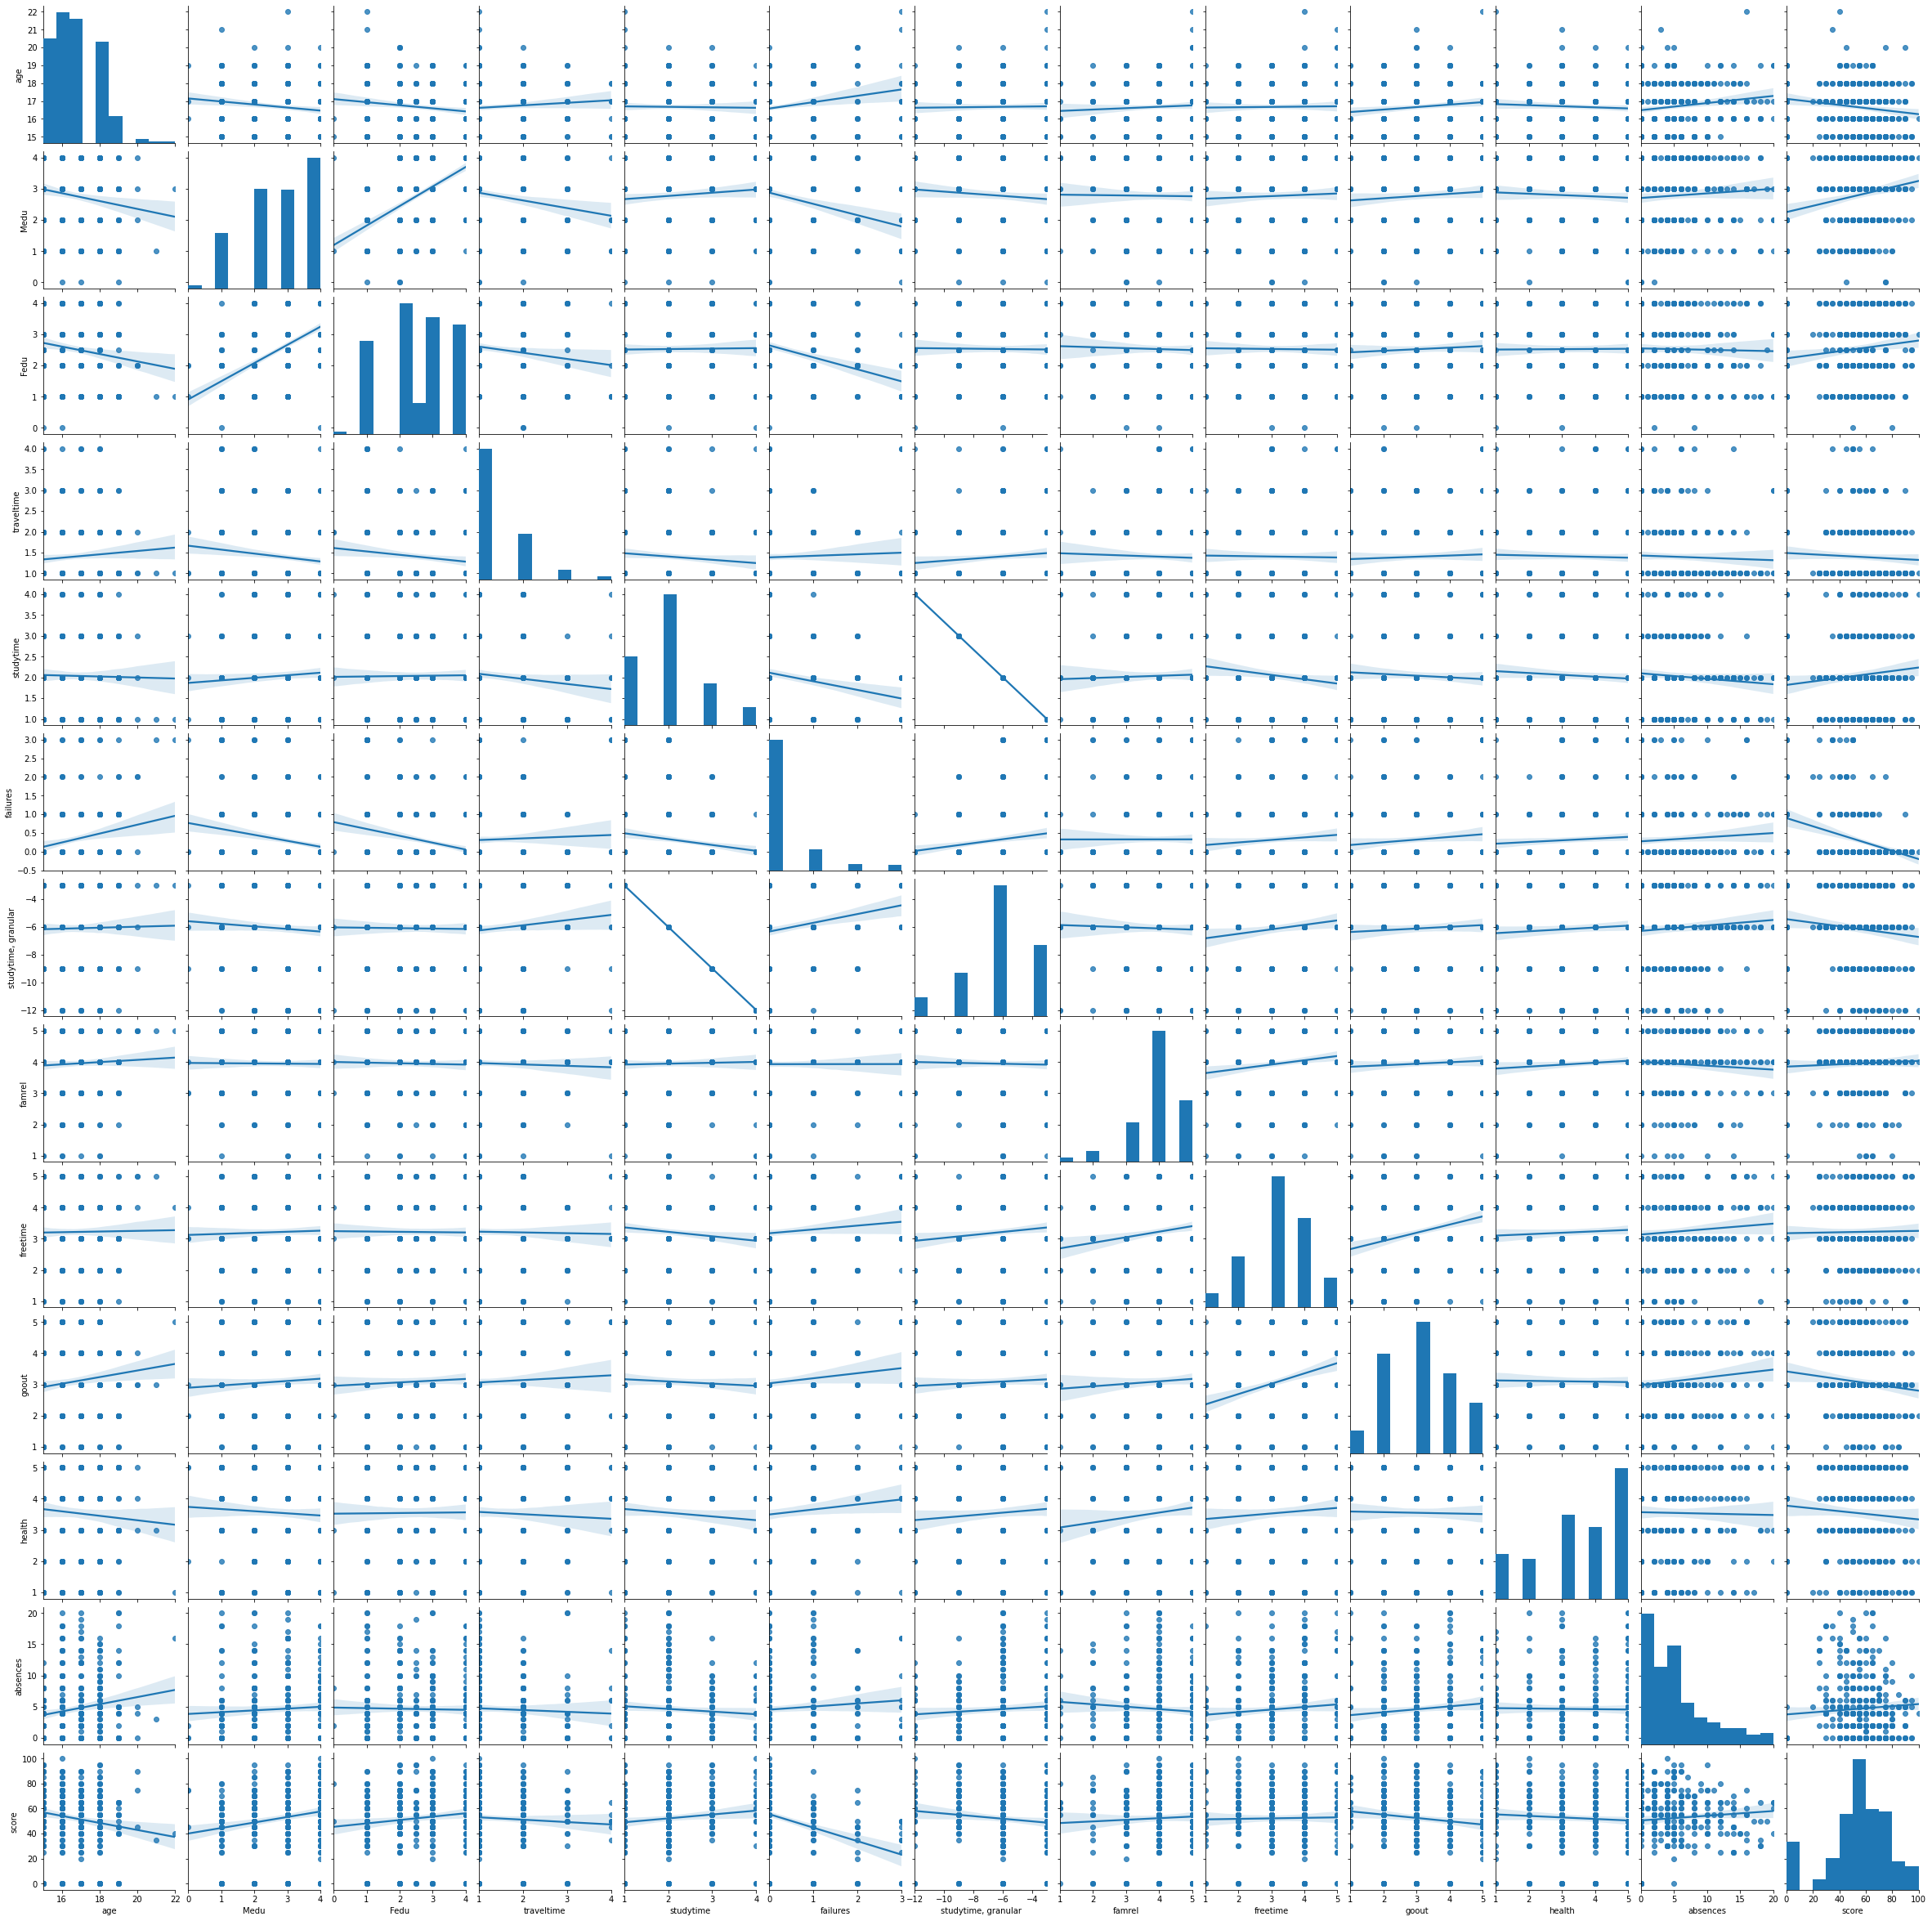

In [16]:
# графический вывод корреляционного анализа
sns.pairplot(df, kind='reg')

In [17]:
# вывод матрицы корреляции
df.corr()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.146405,-0.143462,0.076013,-0.018019,0.205919,0.018227,0.053021,0.013994,0.121057,-0.065719,0.151216,-0.155726
Medu,-0.146405,1.000000,0.603977,-0.152597,0.079513,-0.239840,-0.080125,-0.009936,0.037699,0.071235,-0.054431,0.064609,0.209758
Fedu,-0.143462,0.603977,1.000000,-0.127298,0.012195,-0.265942,-0.012236,-0.025674,-0.011147,0.052460,0.008136,-0.020012,0.124582
traveltime,0.076013,-0.152597,-0.127298,1.000000,-0.098226,0.040891,0.099356,-0.034992,-0.016696,0.046390,-0.035852,-0.039693,-0.056535
studytime,-0.018019,0.079513,0.012195,-0.098226,1.000000,-0.180421,-1.000000,0.027460,-0.122057,-0.053554,-0.072790,-0.074668,0.114295
failures,0.205919,-0.239840,-0.265942,0.040891,-0.180421,1.000000,0.181947,0.000761,0.091245,0.107827,0.085513,0.074250,-0.344338
"studytime, granular",0.018227,-0.080125,-0.012236,0.099356,-1.000000,0.181947,1.000000,-0.027886,0.123897,0.054087,0.073349,0.074902,-0.115741
famrel,0.053021,-0.009936,-0.025674,-0.034992,0.027460,0.000761,-0.027886,1.000000,0.156171,0.061699,0.099614,-0.069736,0.048896
freetime,0.013994,0.037699,-0.011147,-0.016696,-0.122057,0.091245,0.123897,0.156171,1.000000,0.294450,0.063718,0.085038,0.017481
goout,0.121057,0.071235,0.052460,0.046390,-0.053554,0.107827,0.054087,0.061699,0.294450,1.000000,-0.016427,0.107636,-0.127742


Выводы по результатам корреляционного анализа:
1. Переменные studytime и studytime, granular имеют полную отрицательную корреляцию
(соответственно studytime, granular определяет противоположную studytime величину -
сколько ученик проводит времени не связанного с учебой), одна из переменных может
быть исключена.
2. Переменные traveltime, famrel, freetime, health, absences имеют очень слабую
корреляцию менее 0.1 с целевой переменной score и могут быть исключены

In [18]:
df = df.drop(columns=['studytime, granular'])
df = df.drop(columns=['traveltime', 'famrel',
                      'freetime', 'health', 'absences'])

### 5. Анализ и отбор номинативных переменных

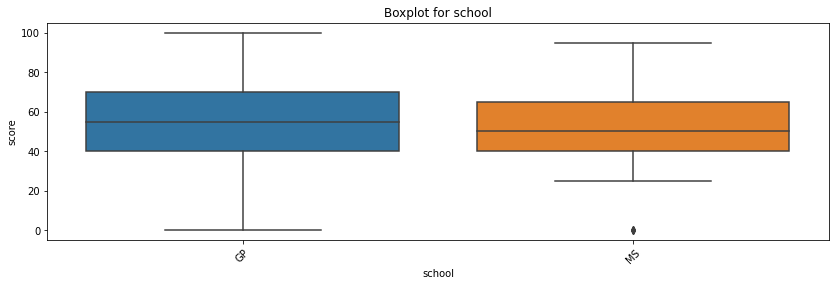

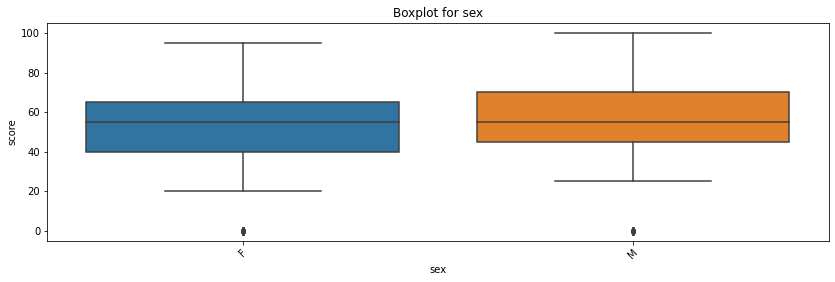

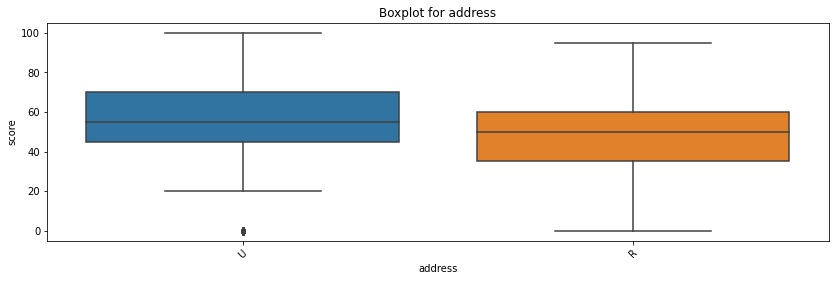

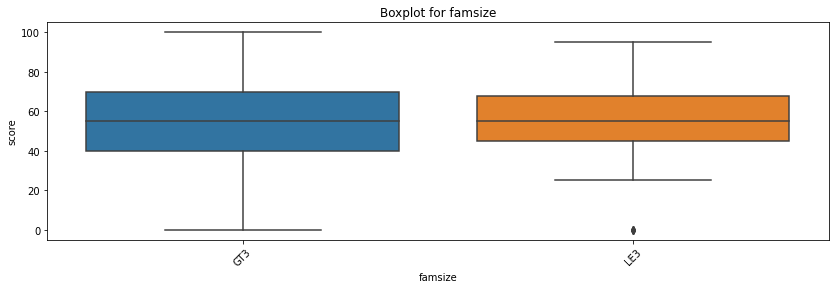

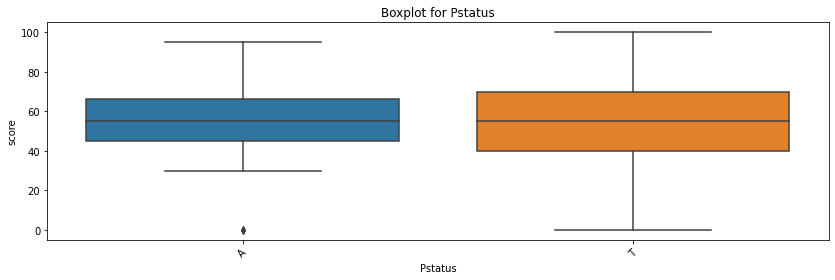

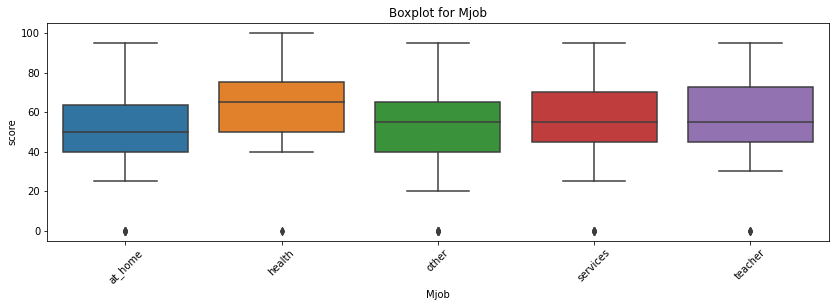

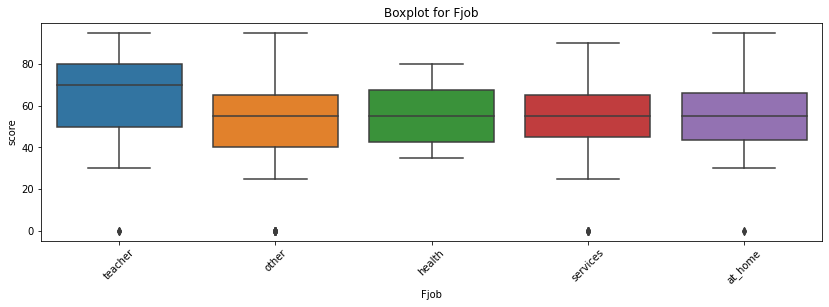

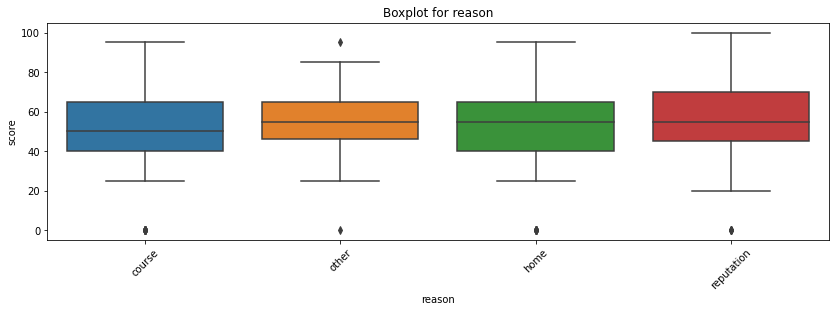

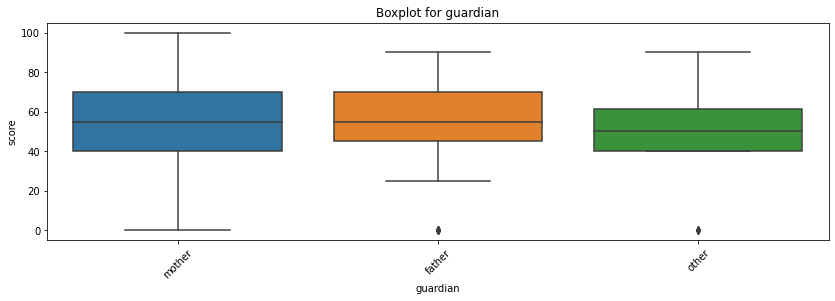

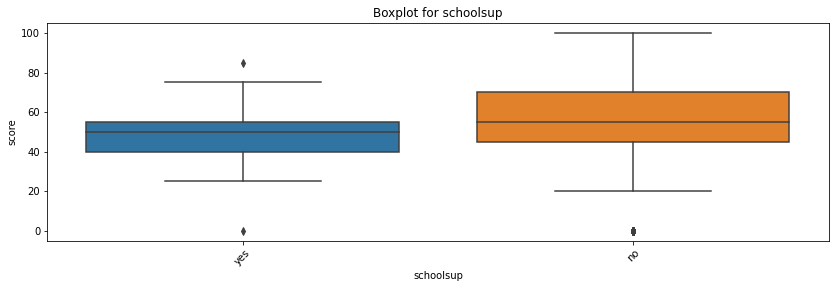

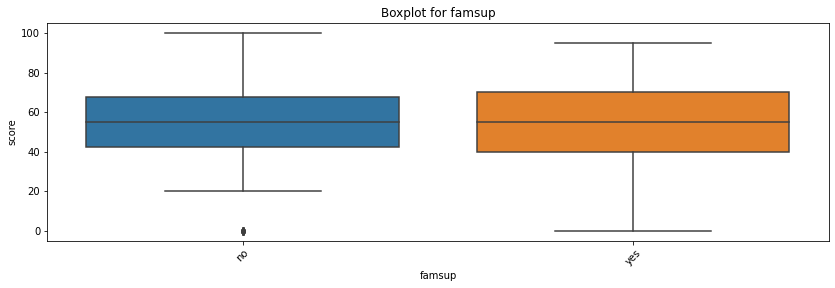

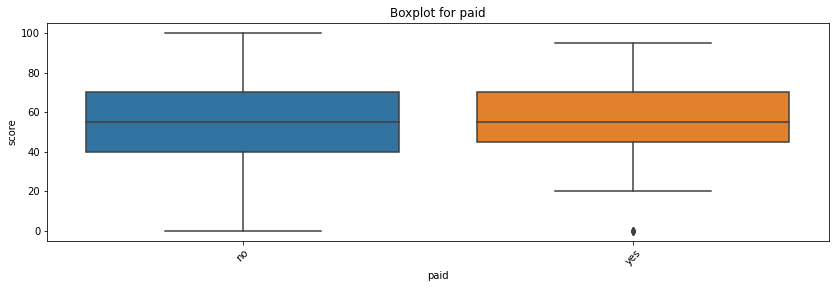

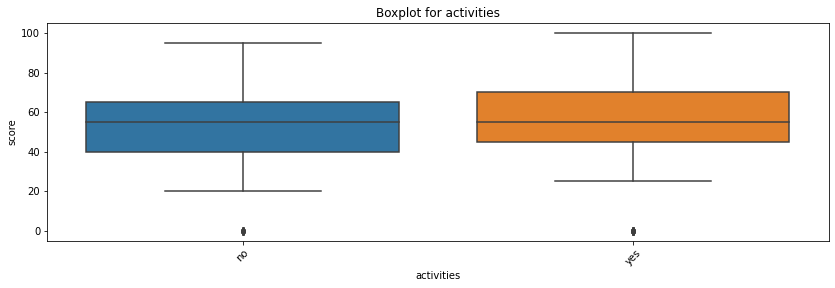

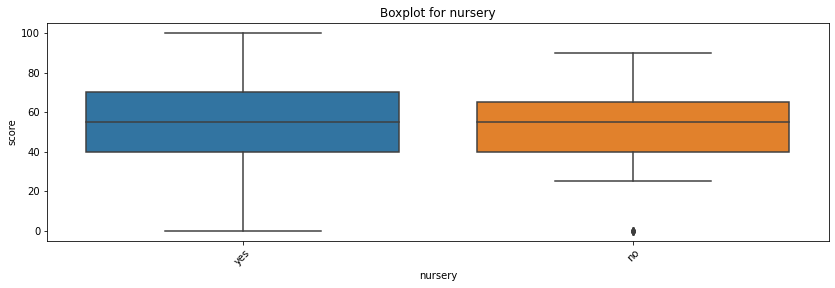

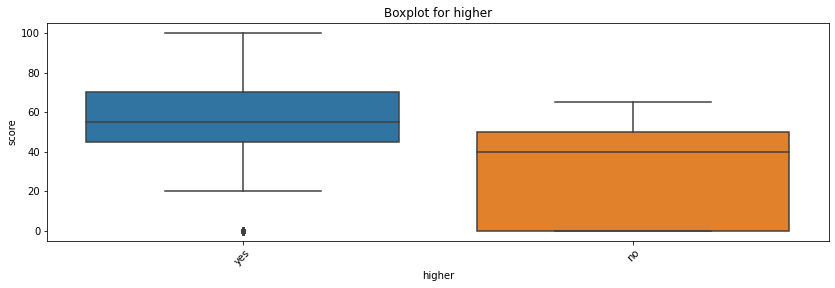

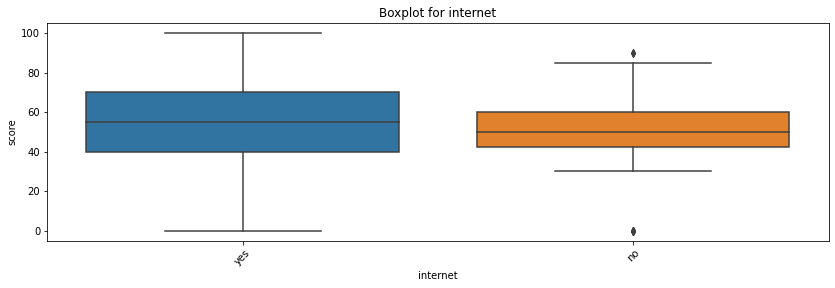

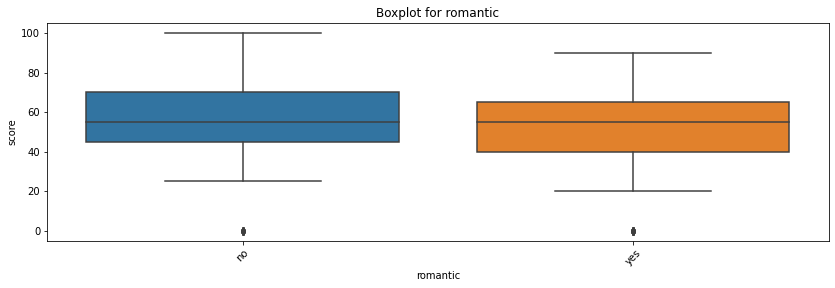

In [19]:
# графический анализ номинативных переменных
for column in df.columns:
    if df[column].dtype == 'object':
        get_boxplot(df, column)

In [20]:
# анализ номинативных переменных с помощью теста Стьюдента
# вывод результата по каждой переменной
for column in df.columns:
    if df[column].dtype == 'object':
        get_stat_dif(df, column)

Cтатистически значимые различия для колонки school не найдены!
Cтатистически значимые различия для колонки sex не найдены!
Найдены статистически значимые различия для колонки address
Cтатистически значимые различия для колонки famsize не найдены!
Cтатистически значимые различия для колонки Pstatus не найдены!
Найдены статистически значимые различия для колонки Mjob
Cтатистически значимые различия для колонки Fjob не найдены!
Cтатистически значимые различия для колонки reason не найдены!
Cтатистически значимые различия для колонки guardian не найдены!
Cтатистически значимые различия для колонки schoolsup не найдены!
Cтатистически значимые различия для колонки famsup не найдены!
Cтатистически значимые различия для колонки paid не найдены!
Cтатистически значимые различия для колонки activities не найдены!
Cтатистически значимые различия для колонки nursery не найдены!
Найдены статистически значимые различия для колонки higher
Cтатистически значимые различия для колонки internet не найдены

In [21]:
# исключаем переменные не имеющие статистически значимых различий в значениях
df = df.drop(columns=['school', 'sex', 'famsize', 'Pstatus', 'Fjob', 'reason',
                      'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
                      'nursery', 'internet'])

### Выводы по итогам.
- данные имеют небольшое количество пустых значений
- выбросы были обнаружены и удалены
- отсутствующие данные были заполнены лигически оптимальными значениями (медианными для данных и фиксированными значеними и  округленными средними для столбца absences
- пустые значения в сотбцах для заполнения которых недостаточно информации оставлены пустыми
- score -основной сотлбец, будующая модель должна будет предсказывать значения данного столбца, для разработки более точной модели, строки с пустыми значеними данного столбца были удалены
- с помощью матрицы корреляции и теста Стьюдента для номинативных переменных получилось выделить важные переменные (age, address, Medu, Fedu, Mjob, studytime, failures, highter, romantic и goout)в датесете для дальнейшего построения модели.

In [24]:
df.head(5)

,age,address,Medu,Fedu,Mjob,studytime,failures,higher,romantic,goout,score
0,18,U,4.0,4.0,at_home,2.0,0.0,yes,no,4.0,30.0
1,17,U,1.0,1.0,at_home,2.0,0.0,yes,no,3.0,30.0
2,15,U,1.0,1.0,at_home,2.0,3.0,yes,NaN,2.0,50.0
3,15,U,4.0,2.0,health,3.0,0.0,yes,yes,2.0,75.0
4,16,U,3.0,3.0,other,2.0,0.0,yes,no,2.0,50.0
